## Cookie Cat: A/B Testing & Hypothesis Testing

### Background
[Cookie Cats](https://www.facebook.com/cookiecatsgame) is a hugely popular mobile puzzle game developed by [Tactile Entertainment](https://tactilegames.com). It's a classic "connect three"-style puzzle game where the player must connect tiles of the same color to clear the board and win the level.

As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention. 

### Business problem
Decide whether to move the gate from level 30 to 40 by looking at the retention rates for both groups.

### Steps
1. Importing and understanding data
2. Detecting problems (missing values, outliers)
3. AB testing
    - Check for assumption: test for normality, equal variance
    - Check if groups are different: test for similarity (equal variance test)
4. Summary of stats
5. Conclusion

## Step 1: Importing Data

The data is from 90,189 players that installed the game while the AB-test was running. The variables are:

- userid - a unique number that identifies each player.
- version - whether the player was put in the control group (gate_30 - a gate at level 30) or the test group (gate_40 - a gate at level 40).
- sum_gamerounds - the number of game rounds played by the player during the first week after installation
- retention_1 - did the player come back and play 1 day after installing?
- retention_7 - did the player come back and play 7 days after installing?


When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40.

In [150]:
# importing necessary libraries and packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [151]:
# import data
df = pd.read_csv('cookie_cats.csv')

# a brief look at the data
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


## Step 2: Detecting Anomalies

Let's look deeper into the data before analyzing the AB-testing result. By looking at the min, max and mean values, we can see that there is a value that appeared to be much larger than the rest. We can further confirm that by looking at the box plot distribution.

In [153]:
df.describe()

,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


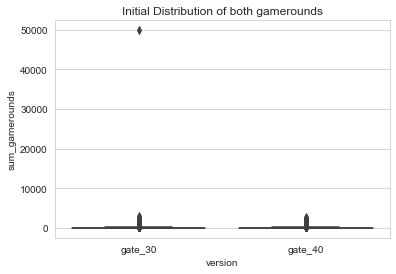

In [154]:
# mean is 51 but max is 49854 --> outlier(s) exist
initial_plot = sns.boxplot(x=df.version, y=df.sum_gamerounds)
plt.title("Initial Distribution of both gamerounds")
plt.show(initial_plot)

# --> there's outliers in gate 30 version (an extremely large value)

As shown in the box plot, there is one gamerounds value at roughly 50000, whereas the rest of them are below 5000 (with a mean of 51.8). That extremely large value appears to be an outlier. Let's remove that and look at the statistics again.

In [68]:
# let's remove the outlier (remove the maximum value)
df = df[df.sum_gamerounds < df.sum_gamerounds.max()] 

In [69]:
# take a look at the data after removing max value
df.describe()

,userid,sum_gamerounds
count,9.018800e+04,90188.000000
mean,4.998397e+06,51.320253
std,2.883298e+06,102.682719
min,1.160000e+02,0.000000
25%,2.512211e+06,5.000000
50%,4.995804e+06,16.000000
75%,7.496461e+06,51.000000
max,9.999861e+06,2961.000000


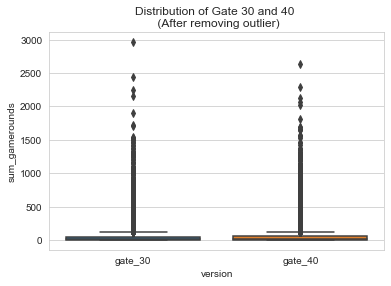

In [71]:
# and the box plot
cleaned = sns.boxplot(x=df.version, y=df.sum_gamerounds)
plt.title("Distribution of Gate 30 and 40 \n (After removing outlier)")
plt.show(cleaned)

## Step 3: A/B Test

In this section, we will look at the A/B testing result. Specifically, we will be doing the following:
1. Check the A/B test data to see if the two groups have roughly the same number of players
2. Check if there is a statiscally significant difference between the two groups

In [155]:
# check group distribution
df.version.value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

The number of players in both groups are roughly the same. We can move onto checking similarity between the two groups. 

We will start off by testing if the gamerounds data are normally distributed. If both datasets pass normality test, we will run a pararmetric test, if not then we will run a non-parametric test.

In [126]:
# splitting data into A/B groups
group_a = df[df['version']=="gate_30"]['sum_gamerounds'].tolist()
group_b = df[df['version']=="gate_40"]['sum_gamerounds'].tolist()

# test for normality
pval_a = stats.normaltest(group_a).pvalue
pval_b = stats.normaltest(group_b).pvalue

if pval_a > 0.05 and pval_b > 0.05:
    print("Both groups passed normality test!")
else:
    print("At least one group did not pass normality test")

At least one group did not pass normality test


Here, since the data is not normally distributed, we will apply a non-parametric test: Mann Whitney U-test to see if the two groups have a statistically significant difference.

In [129]:
# checking difference between groups

# need to use non-parametric test 
# --> apply non-parametric test: Mann-Whitney U-test

mann_result = stats.mannwhitneyu(group_a, group_b).pvalue 

if (mann_result < 0.05): # reject H0
    print("Two groups are not similar")
else: # H0
    print("Two samples are similar")

Two groups are not similar


After applying the Mann Whitney U-test, we get a p-value less than 0.05, which indicates that the A/B groups are not similar!

## Step 4: Summary and Stats

In this step, we will look at the 1-day and 7-day retention rates for both groups, and use this to derive our conclusion.

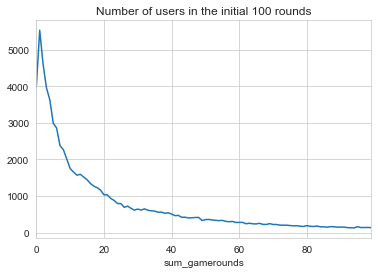

In [130]:
# number of players by gamerounds
players_by_round = df.groupby('sum_gamerounds')['userid'].count()[:100]
players_by_round_plot = players_by_round.plot(x='sum_gamerounds', y='userid')
plt.title("Number of users in the initial 100 rounds")
plt.show(players_by_round_plot)

In [131]:
# number of players
print("Number of unique players: ", df.userid.nunique())

# number of players that downloaded the game but did not play at all
print("Did not play the game: ", players_by_round[0])

Number of unique players:  90188
Did not play the game:  3994


In [144]:
# looking at the retentions for both groups

# first split the data by gates
gate_30 = df[df['version']=="gate_30"]
gate_40 = df[df['version']=="gate_40"]

# difference between total game rounds

df.groupby('version').sum_gamerounds.mean()

version
gate_30    51.342111
gate_40    51.298776
Name: sum_gamerounds, dtype: float64

In [157]:
# difference between retentions

# total retention
ret_total = pd.DataFrame({
                "Retention_1day": df["retention_1"].value_counts(),
                "Retention_7day": df["retention_7"].value_counts(),
                "Ratio_1day": df["retention_1"].value_counts() / len(df),
                "Ratio_7day": df["retention_7"].value_counts() / len(df)
            })

ret_total

,Retention_1day,Retention_7day,Ratio_1day,Ratio_7day
False,50036,73408,0.55479,0.813935
True,40153,16781,0.44521,0.186065


In [158]:
# retention for gate_30

ret_30 = pd.DataFrame({
            "Retention_1day": gate_30["retention_1"].value_counts(),
            "Retention_7day": gate_30["retention_7"].value_counts(),
            "Ratio_1day": gate_30["retention_1"].value_counts() / len(gate_30),
            "Ratio_7day": gate_30["retention_7"].value_counts() / len(gate_30)
            })

ret_30

,Retention_1day,Retention_7day,Ratio_1day,Ratio_7day
False,24665,36198,0.551802,0.809817
True,20034,8501,0.448198,0.190183


From the above table we can see that the retention rate for gate_30:
- 1-day: 44.8%
- 7-day: 19.0%

In [159]:
# retention for gate_40

ret_40 = pd.DataFrame({
            "Retention_1day": gate_40["retention_1"].value_counts(),
            "Retention_7day": gate_40["retention_7"].value_counts(),
            "Ratio_1day": gate_40["retention_1"].value_counts() / len(gate_40),
            "Ratio_7day": gate_40["retention_7"].value_counts() / len(gate_40)
            })

ret_40

,Retention_1day,Retention_7day,Ratio_1day,Ratio_7day
False,25370,37210,0.557717,0.818
True,20119,8279,0.442283,0.182


The retention rate for gate_40:
- 1-day: 44.2%
- 7-day: 18.2%

### Detailed Summary

By looking at the data and the above short analysis, we can conclude the following statistical summaries:

**General**
- Users play a total of 52 game rounds on average
- 3994 (or roughly 4.5% of) users never played the game after installing
- 55.5% of users quit the game after 1 day of installing (44.5% retention)
- 81% of users quit the game after 7 days of installing (19% retention)

**1-Day Retention Comparison**
- 44.8% of gate_30 users continue to play the game after 1-day
- 44.2% of gate_40 users continue to play the game after 1-day

**7-Day Retention Comparison**
- 19.0% of gate_30 users continue to play the game after 1-day
- 18.2% of gate_40 users continue to play the game after 1-day

## Step 5: Conclusion

Let's go back to the business problem! **Should we or should we not move the gate from level 30 to 40? Does moving gate to level 40 has an impact on player retention?**

In short, we should **NOT** move the gate from level 30 to level 40. 

Both 1-day and 7-day retentions are higher when the gate is set at level 30. Although the differences are small (roughly 1% difference), the Mann-Whitney U-test tells us that the groups are not similar. Therefore there is a statistical difference in the total game rounds played between moving gates from level 30 to level 40. 

**Why is it better to keep the gate at 30?**

Naturally, we would think that placing the gate earlier may be why users quit the game since they are forced to either wait for a certain period or make an in-app purchase before proceeding to the next level. However, this can be explained by a psychological theory called Hedonic Adaptation.

Hedonic Adaptation is a human tendency to lose happiness to a life event or an activity quickly. The idea can also be understood as to how human has unlimited desires — a higher salary would increase our level of happiness for a while. However, we would soon be expecting more, bringing us back to the initial level of happiness. 

By keeping the gate at level 30, we keep the users in the happiness loop and prevent them from quitting the game just because they got bored of it. Thus, users' level of happiness is prolonged when they are forced to take a break. Of course, if we were to find the optimal solution to this, there are other factors that we need to consider: such as the wait time, price of in-app purchases, ... etc.

